In [99]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

np.random.seed(42)

In [100]:
YX_train = pd.read_csv('train_dataset.csv')
YX_test = pd.read_csv('test_dataset.csv')
Y = YX_train['fake_binary']
X = YX_train.drop(columns=['fake_binary'])

In [101]:
# Combine features and target into a single DataFrame for resampling
df_combined = X.copy()
df_combined['fake_binary'] = Y

In [102]:
# Apply SMOTE to balance the 'party_detailed' variable along with other features and target
smote = SMOTE(random_state=42)
df_resampled_party, target_resampled_party = smote.fit_resample(df_combined, df_combined['party_detailed'])

In [103]:
df_resampled_party['party_detailed'].value_counts()

party_detailed
1    800
0    800
Name: count, dtype: int64

In [104]:
df_resampled_party['fake_binary'].value_counts()

fake_binary
0    1174
1     426
Name: count, dtype: int64

In [105]:
import pickle

# Fit the logistic regression model on the resampled data
model_party = sm.Logit(df_resampled_party['fake_binary'], df_resampled_party.drop(columns=['fake_binary'])).fit_regularized(method='l1')
print("SMOTE Model Summary:")
print(model_party.summary())
pickle.dump(model_party, open('regression_model_Bias.sav', 'wb'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.494692687213672
            Iterations: 130
            Function evaluations: 130
            Gradient evaluations: 130
SMOTE Model Summary:
                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1574
Method:                           MLE   Df Model:                           25
Date:                Tue, 04 Jun 2024   Pseudo R-squ.:                  0.1463
Time:                        17:04:15   Log-Likelihood:                -791.51
converged:                       True   LL-Null:                       -927.19
Covariance Type:            nonrobust   LLR p-value:                 3.165e-43
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

In [106]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled_fake, y_resampled_fake = smote.fit_resample(X, Y)

# Convert resampled data back to DataFrame for compatibility with statsmodels
X_resampled_fake = pd.DataFrame(X_resampled_fake, columns=X.columns)
y_resampled_fake = pd.Series(y_resampled_fake)
Xy_resampled_fake = pd.concat([X_resampled_fake, y_resampled_fake], axis=1)

In [107]:
y_resampled_fake.value_counts()

fake_binary
1    1055
0    1055
Name: count, dtype: int64

In [108]:
# Fit the logistic regression model on the resampled data
model_fake = sm.Logit(y_resampled_fake, X_resampled_fake).fit_regularized(method='l1')
print("SMOTE Model Summary:")
print(model_fake.summary())
pickle.dump(model_fake, open('regression_model_Bias2.sav', 'wb'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5817833102541331
            Iterations: 149
            Function evaluations: 149
            Gradient evaluations: 149
SMOTE Model Summary:
                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 2110
Model:                          Logit   Df Residuals:                     2084
Method:                           MLE   Df Model:                           25
Date:                Tue, 04 Jun 2024   Pseudo R-squ.:                  0.1607
Time:                        17:04:25   Log-Likelihood:                -1227.6
converged:                       True   LL-Null:                       -1462.5
Covariance Type:            nonrobust   LLR p-value:                 1.267e-83
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [109]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model_party.params
beta_cov = model_party.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [110]:
# Initialize an array to store predictions from each simulation
predictions_party = np.zeros((n_simulations, df_resampled_party.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(df_resampled_party.drop(columns=['fake_binary']), beta_simulation)
    beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions_party[i] = probabilities

# Derive odds from log-odds coefficients 
simulated_beta_odds = np.exp(simulated_betas)


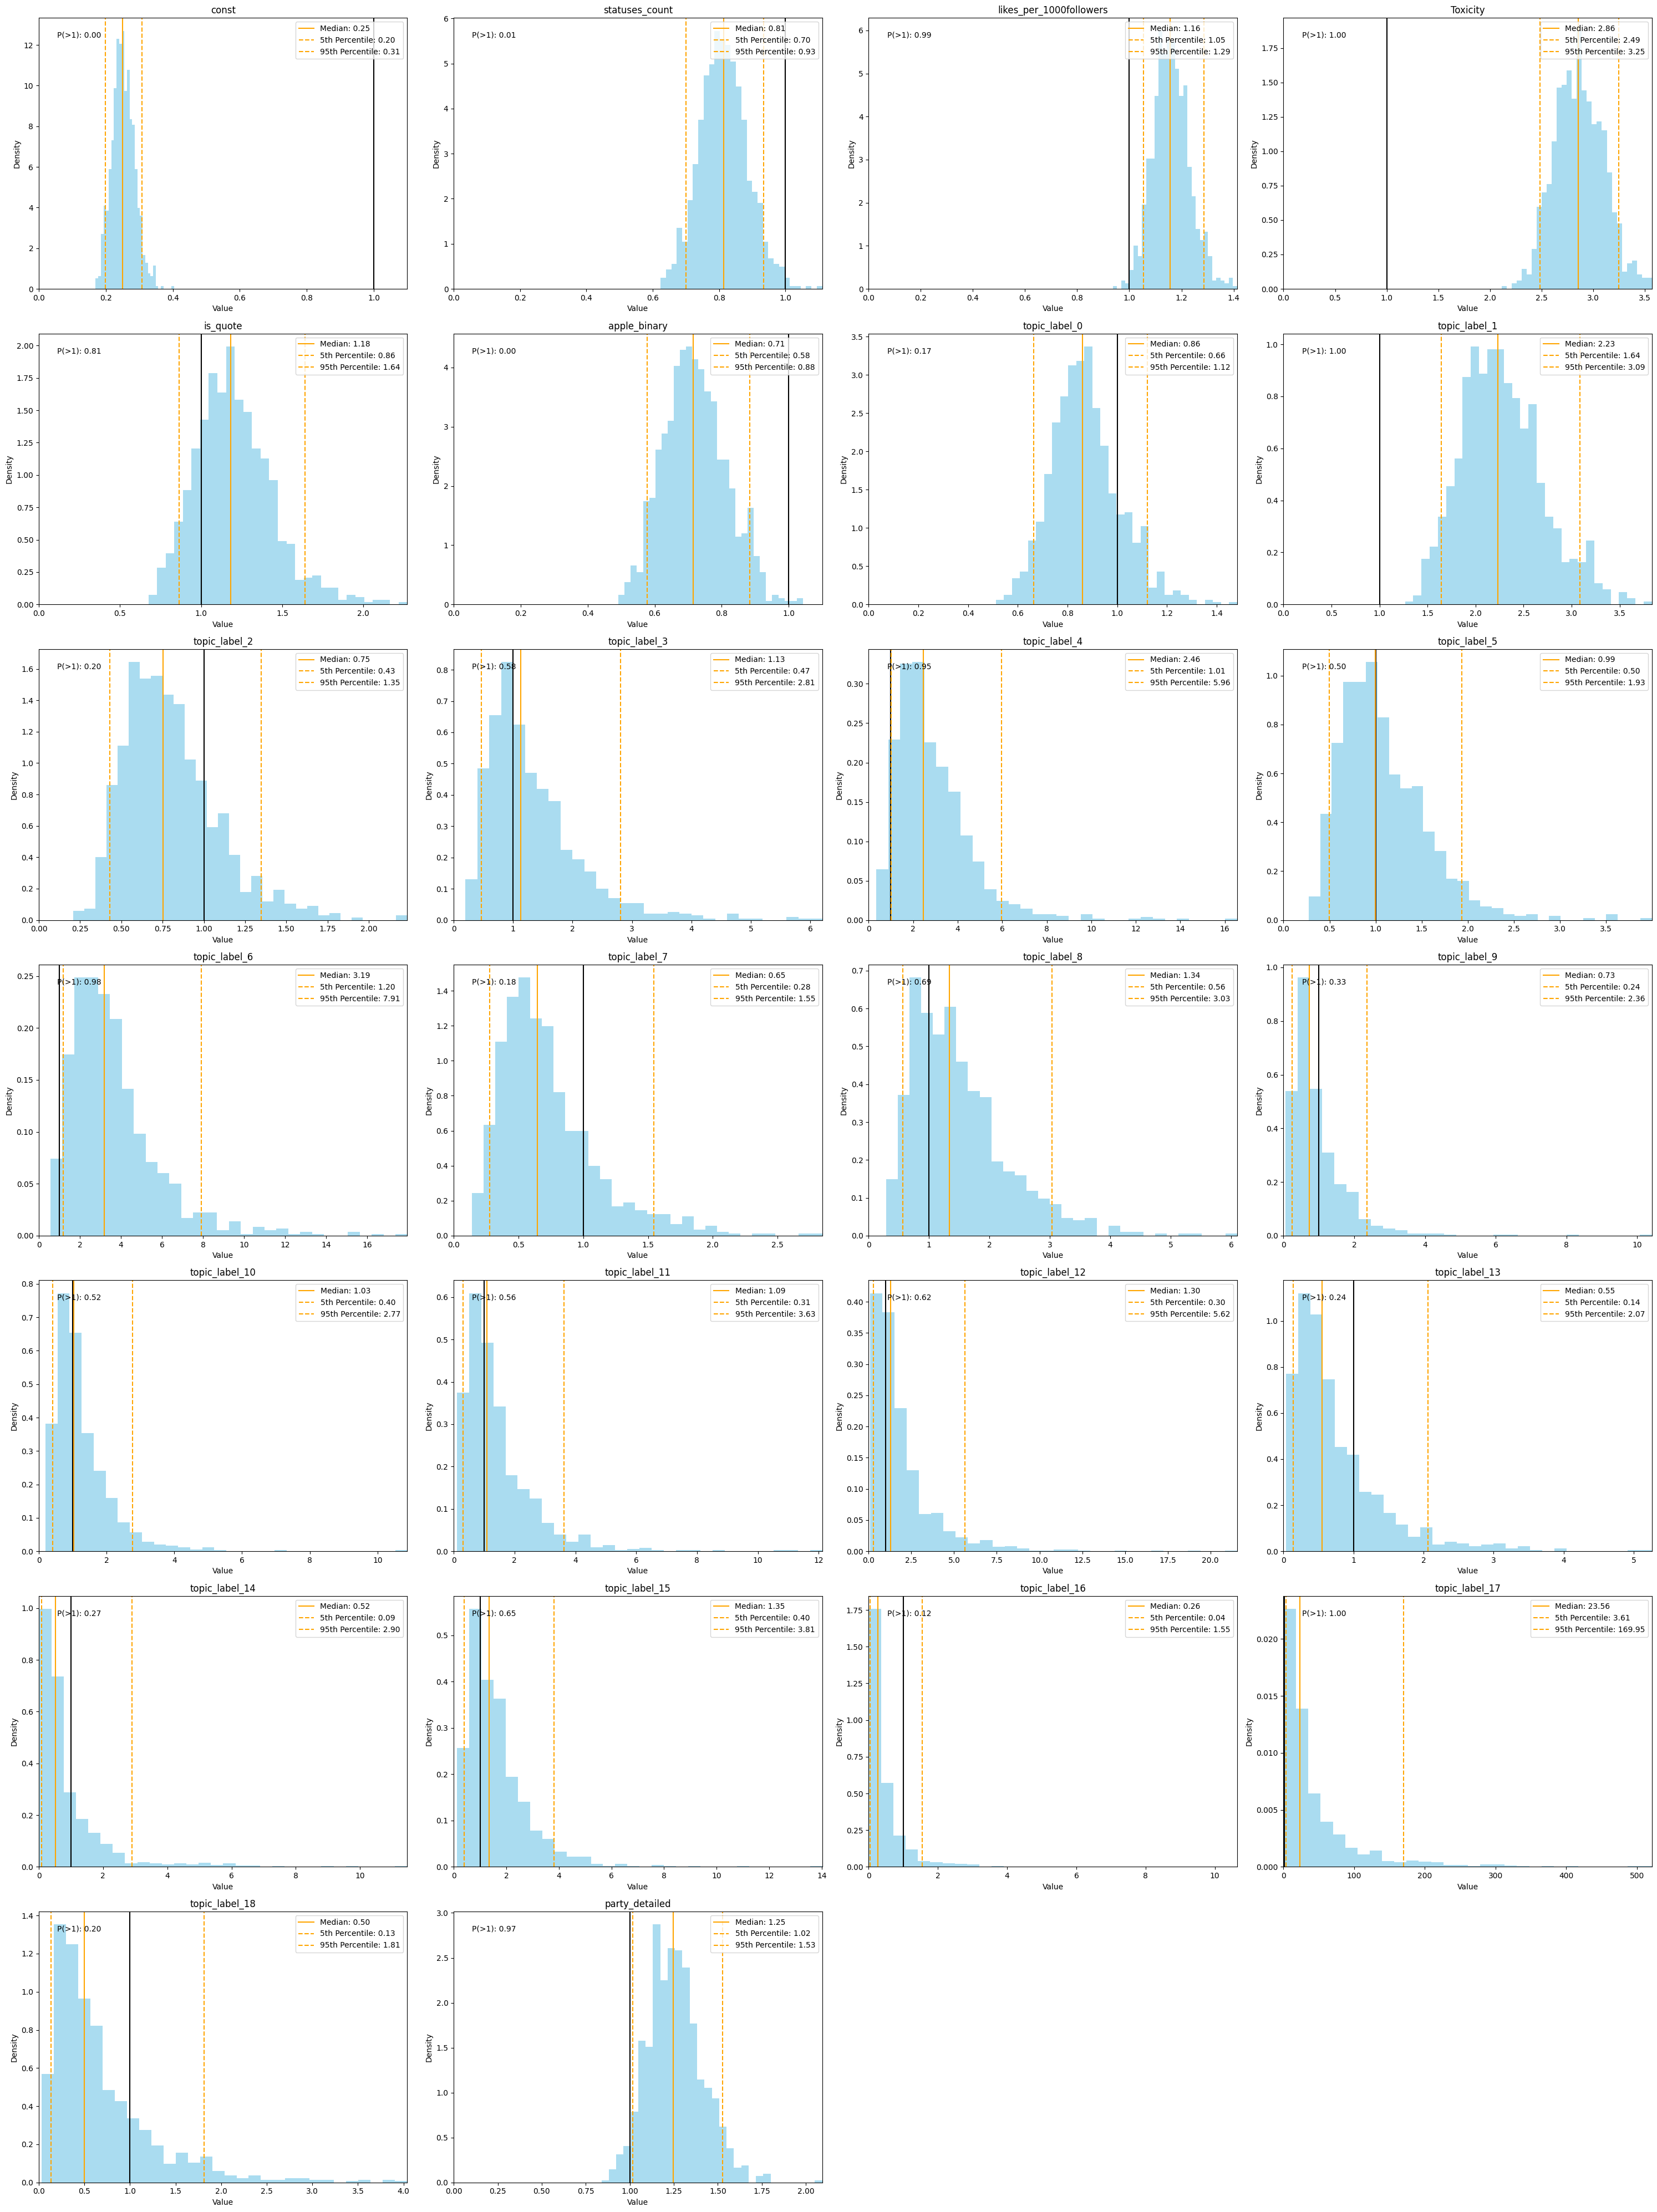

In [111]:
# Calculate statistics for each coefficient
medians = np.median(simulated_beta_odds, axis=0)
lower_quantiles = np.percentile(simulated_beta_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_beta_odds, 95, axis=0)
prob_positive = np.mean(simulated_beta_odds > 1, axis=0)

# Plot names 
col_names = df_resampled_party.drop(columns=['fake_binary']).columns

# Plot histograms of each coefficient
num_plots = simulated_betas.shape[1]
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axs = plt.subplots(num_rows, num_columns, figsize=(30, 40))
axs = axs.flatten()

for i in range(num_plots):
    ax = axs[i]
    ax.hist(simulated_beta_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_beta_odds[:, i]).max())) 
    
# Hide empty subplots
for j in range(num_plots, len(axs)):
    axs[j].axis('off')
    
plt.tight_layout()
plt.show()


In [112]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model_fake.params
beta_cov = model_fake.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [113]:
# Initialize an array to store predictions from each simulation
predictions_fake = np.zeros((n_simulations, Xy_resampled_fake.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(X_resampled_fake, beta_simulation)
    beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions_fake[i] = probabilities

# Derive odds from log-odds coefficients 
simulated_beta_odds = np.exp(simulated_betas)


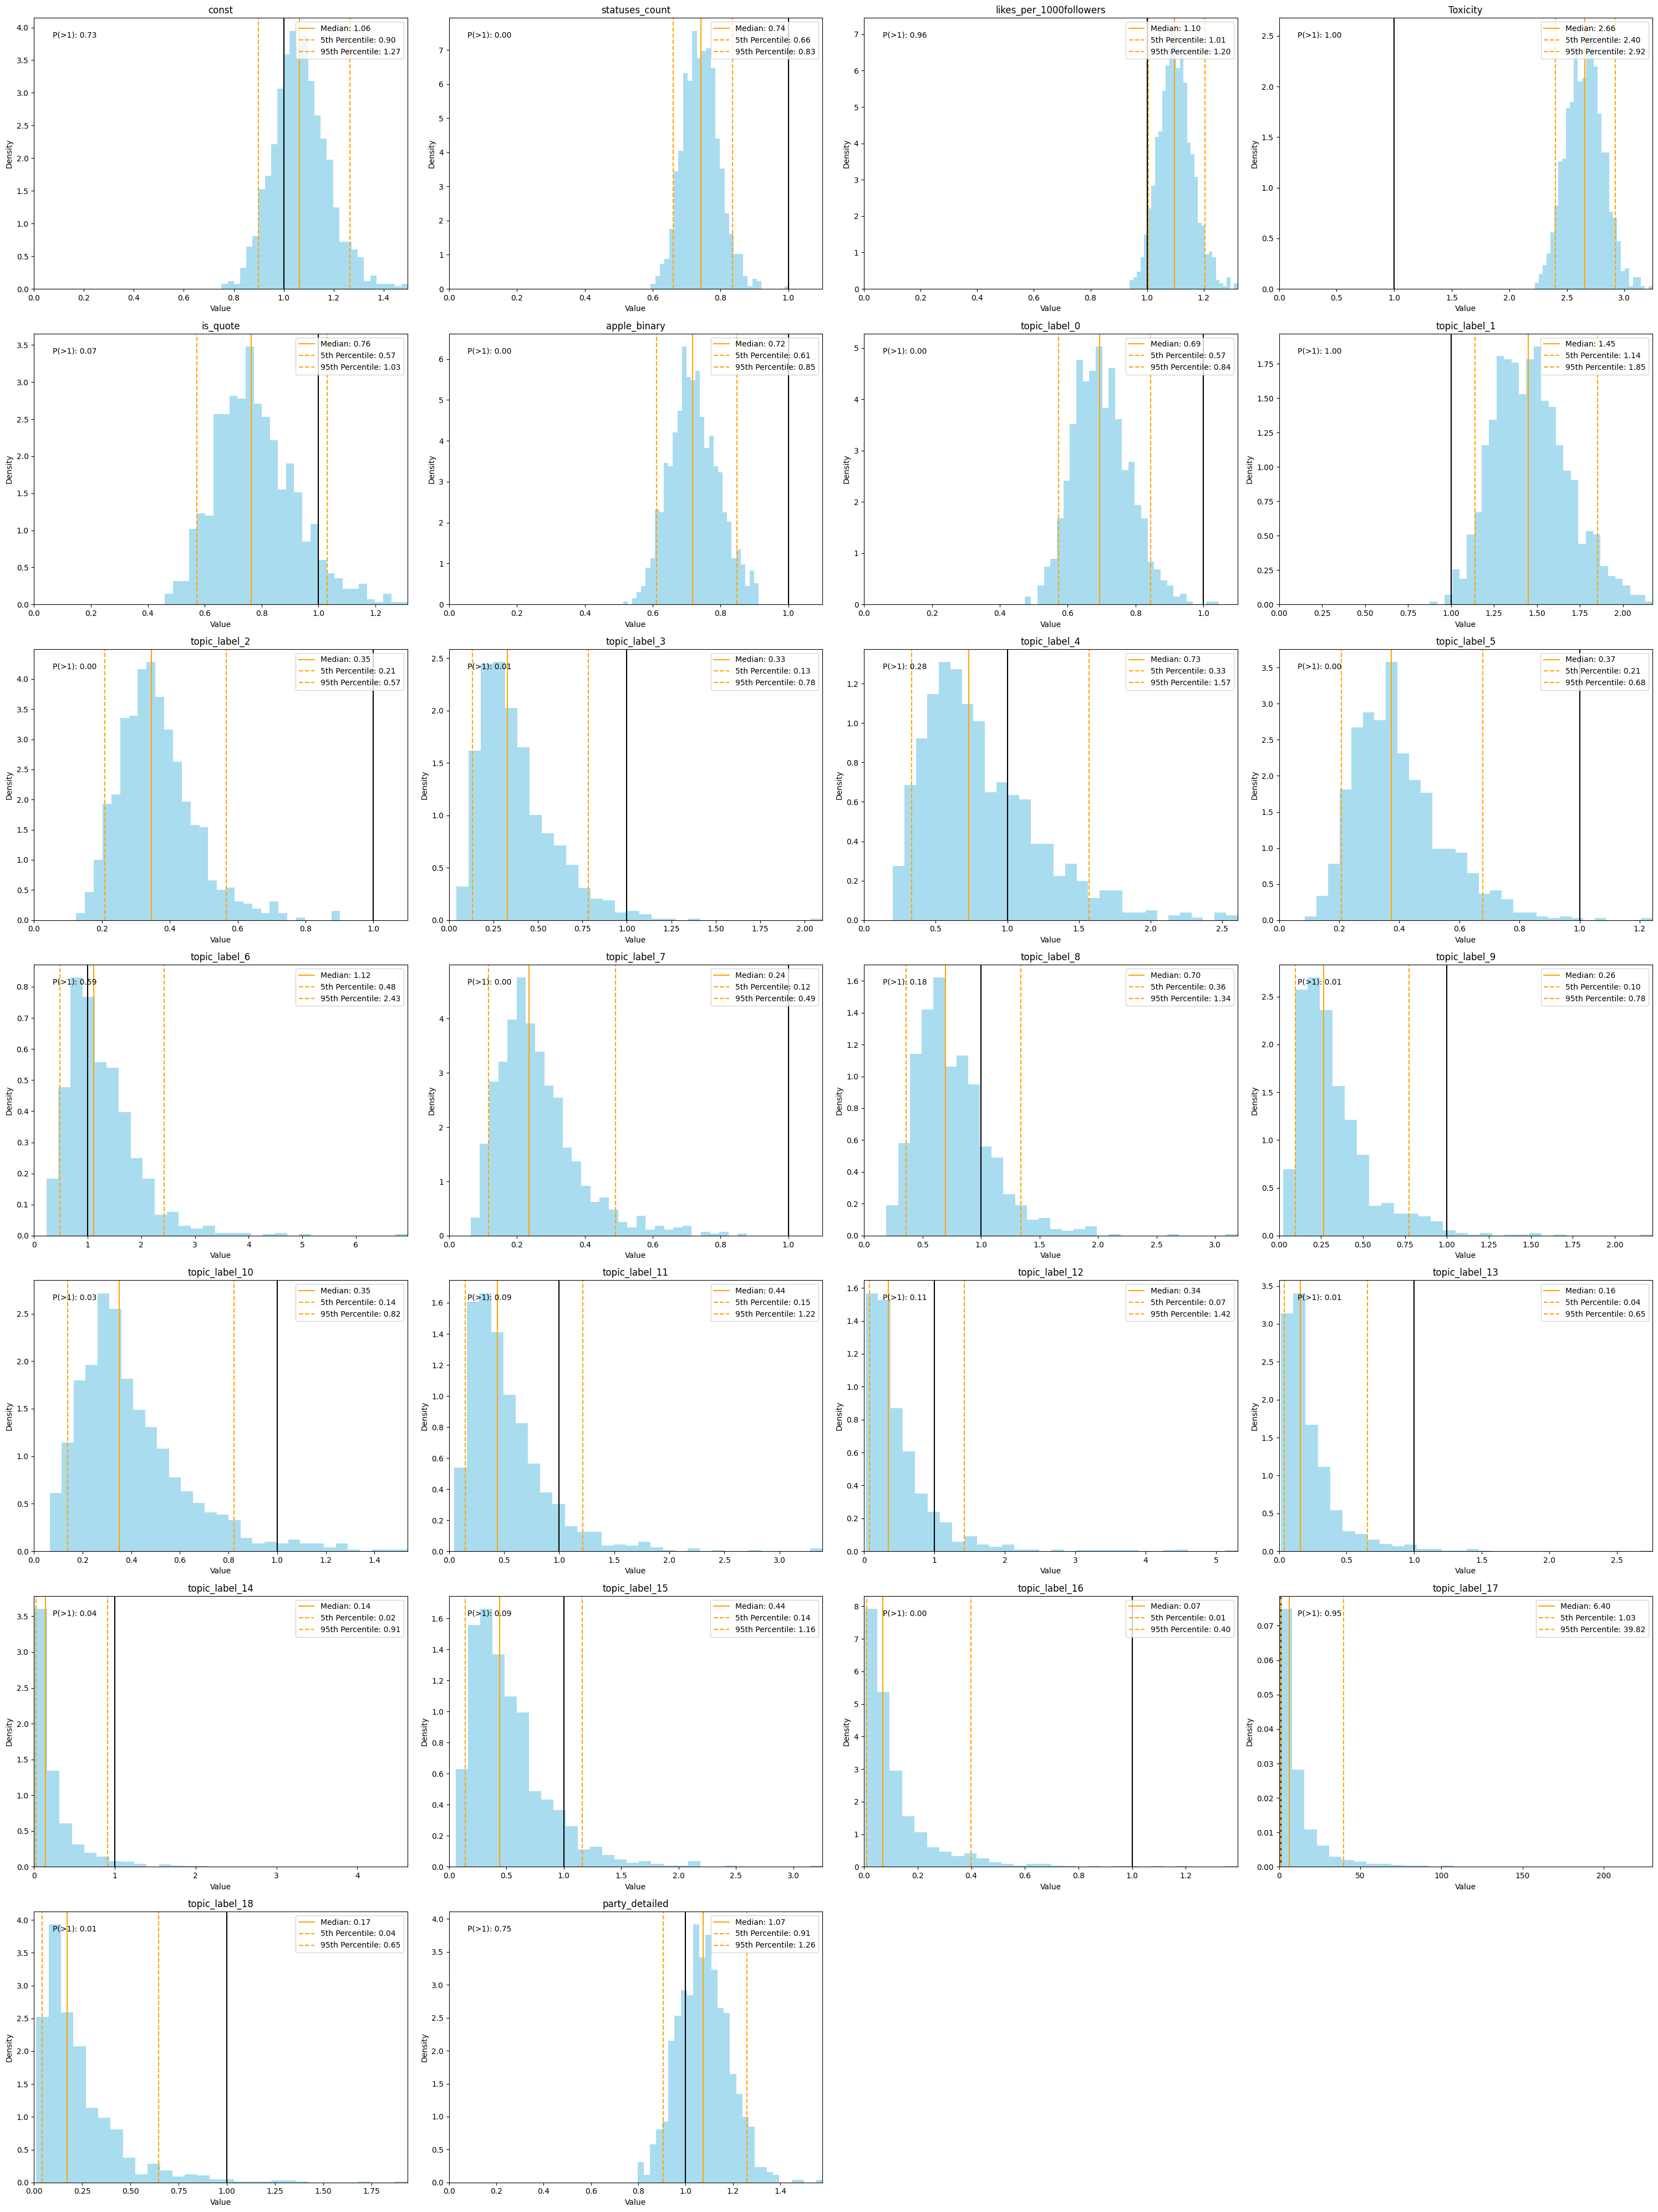

In [114]:
# Calculate statistics for each coefficient
medians = np.median(simulated_beta_odds, axis=0)
lower_quantiles = np.percentile(simulated_beta_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_beta_odds, 95, axis=0)
prob_positive = np.mean(simulated_beta_odds > 1, axis=0)

# Plot names 
col_names = X_resampled_fake.columns

# Plot histograms of each coefficient
num_plots = simulated_betas.shape[1]
num_columns = 4
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axs = plt.subplots(num_rows, num_columns, figsize=(30, 40))
axs = axs.flatten()

for i in range(num_plots):
    ax = axs[i]
    ax.hist(simulated_beta_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_beta_odds[:, i]).max())) 
    
# Hide empty subplots
for j in range(num_plots, len(axs)):
    axs[j].axis('off')
    
plt.tight_layout()
plt.show()


In [115]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

def prop_stat(table1, table2):

    fn1 = table1.values[0][1]  # Number of 'true' in subset 1
    fn2 = table2.values[0][1] # Number of 'true' in subset 2
    fp1 = table1.values[1][0]
    fp2 = table2.values[1][0]

    n1 = table1.values.sum()  # Total observations in subset 1
    n2 = table2.values.sum()   # Total observations in subset 2

    #  the counts and total observations
    count_fn = np.array([fn1, fn2])
    count_fp = np.array([fp1, fp2])
    nobs = np.array([n1, n2])

    # performing the z-test
    stat_fn, pval_fn = proportions_ztest(count_fn, nobs)

    stat_fp, pval_fp = proportions_ztest(count_fp, nobs)

    # results
    print('Z-statistic false negatives:', stat_fn)
    print('P-value false negatives:', pval_fn)
    if pval_fn < 0.05:
        print("There is a statistically significant difference between the two false negative proportions.")
    else:
        print("There is no statistically significant difference between the two false negative proportions.")


    # results
    print('Z-statistic false positives:', stat_fp)
    print('P-value false positives:', pval_fp)
    if pval_fp < 0.05:
        print("There is a statistically significant difference between the two false positive proportions.")
    else:
        print("There is no statistically significant difference between the two false positive proportions.")

    return




In [116]:
republican_index_party = df_resampled_party.index[df_resampled_party['party_detailed'] == 1].tolist()

republican_party = df_resampled_party.loc[republican_index_party]
republican_true_labels_party = republican_party['fake_binary']

republican_model_predictions_party = model_party.predict(republican_party.drop(columns=['fake_binary']).values)
republican_predictions_binary_party = (republican_model_predictions_party >= 0.5).astype(int)

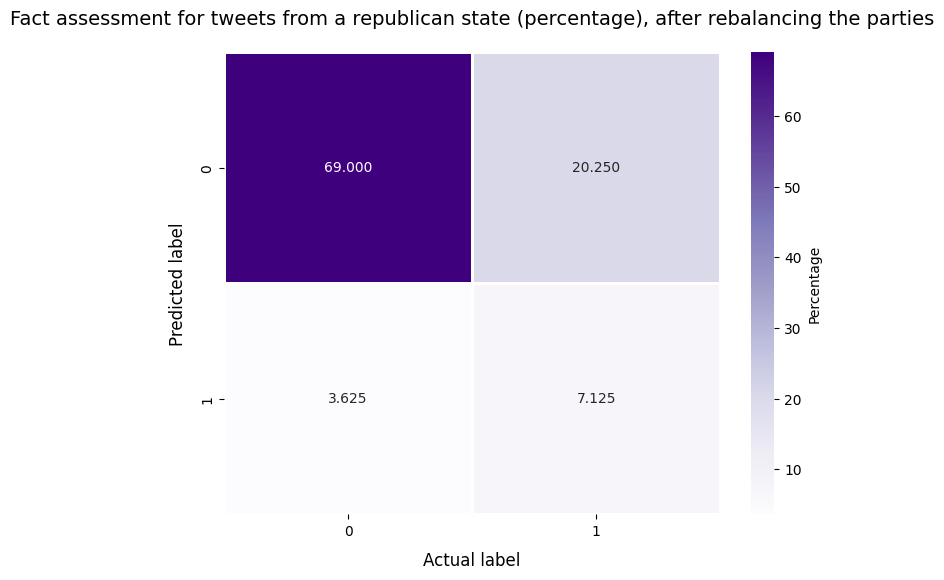

In [117]:
# Creating a crosstab
table1 = pd.crosstab(republican_predictions_binary_party, republican_true_labels_party)

# Calculate total count of all cells
total_count = table1.values.sum()

# Normalizing the table by total count
table_normalized = table1 / total_count * 100

# Rounding for easier interpretation
table_normalized = table_normalized.round(3)

plt.figure(figsize=(8, 6))

# plotting the heatmap 
ax = sns.heatmap(table_normalized, annot=True, cmap="Purples", fmt=".3f", cbar_kws={'label': 'Percentage'},linewidths=1, linecolor="white")

#title 
plt.title("Fact assessment for tweets from a republican state (percentage), after rebalancing the parties", fontsize=14, pad=20)

# the position of the labels and ticks
plt.xlabel('Actual label', fontsize=12, labelpad=10)
plt.ylabel('Predicted label', fontsize=12, labelpad=10)

# displaying the plot
plt.show()


In [118]:
democrat_index_party = df_resampled_party.index[df_resampled_party['party_detailed'] == 0].tolist()

democrat_party = df_resampled_party.loc[democrat_index_party]
democrat_true_labels_party = democrat_party['fake_binary']

democrat_model_predictions_party = model_party.predict(democrat_party.drop(columns=['fake_binary']).values)
democrat_predictions_binary_party = (democrat_model_predictions_party >= 0.5).astype(int)

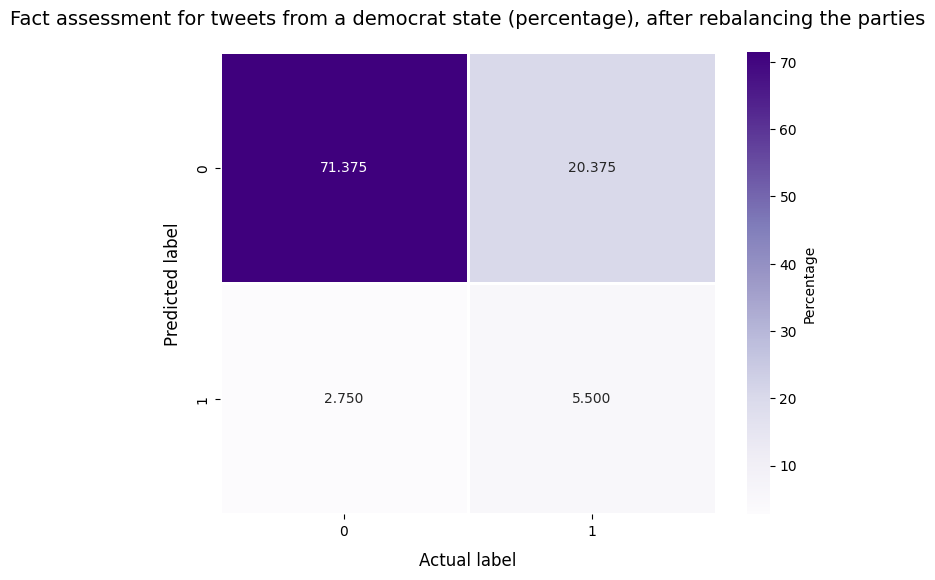

In [119]:
# Creating a crosstab
table2 = pd.crosstab(democrat_predictions_binary_party, democrat_true_labels_party)

# Calculate total count of all cells
total_count = table2.values.sum()

# Normalizing the table by total count
table_normalized = table2 / total_count * 100

# Rounding for easier interpretation
table_normalized = table_normalized.round(3)

plt.figure(figsize=(8, 6))

# plotting the heatmap 
ax = sns.heatmap(table_normalized, annot=True, cmap="Purples", fmt=".3f", cbar_kws={'label': 'Percentage'},linewidths=1, linecolor="white")

#title 
plt.title("Fact assessment for tweets from a democrat state (percentage), after rebalancing the parties", fontsize=14, pad=20)

# the position of the labels and ticks
plt.xlabel('Actual label', fontsize=12, labelpad=10)
plt.ylabel('Predicted label', fontsize=12, labelpad=10)

# displaying the plot
plt.show()


In [120]:
prop_stat(table1, table2)

Z-statistic false negatives: -0.062138850990448066
P-value false negatives: 0.9504522581459892
There is no statistically significant difference between the two false negative proportions.
Z-statistic false positives: 0.996201598844111
P-value false positives: 0.31915220273156464
There is no statistically significant difference between the two false positive proportions.


In [121]:
republican_index_fake = Xy_resampled_fake.index[Xy_resampled_fake['party_detailed'] == 1].tolist()

republican_fake = Xy_resampled_fake.loc[republican_index_party]
republican_true_labels_fake = republican_fake['fake_binary']

republican_model_predictions_fake = model_fake.predict(republican_fake.drop(columns=['fake_binary']).values)
republican_predictions_binary_fake = (republican_model_predictions_fake >= 0.5).astype(int)

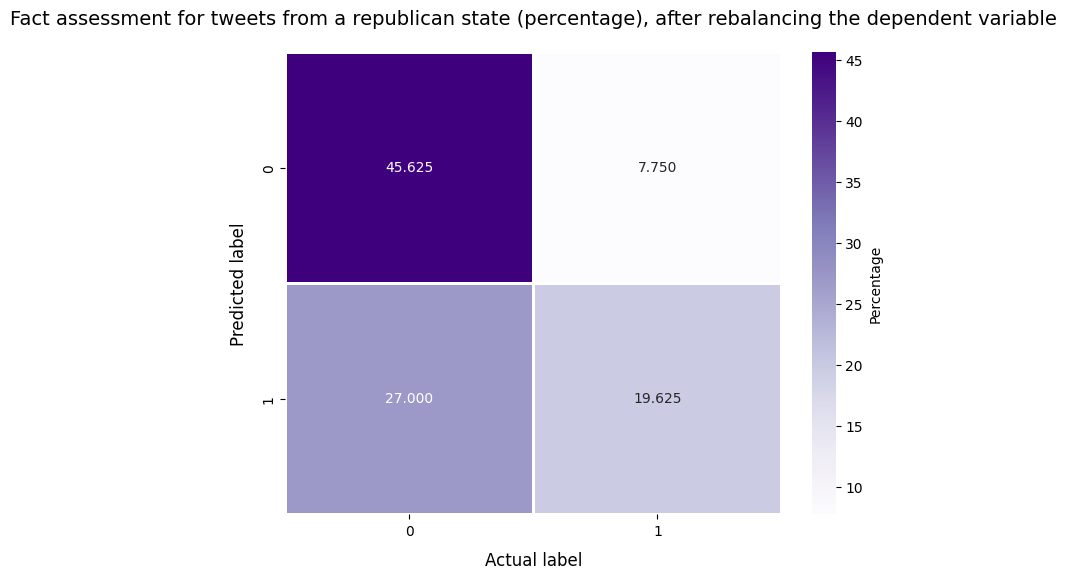

In [122]:
# Creating a crosstab
table3 = pd.crosstab(republican_predictions_binary_fake, republican_true_labels_fake)

# Calculate total count of all cells
total_count = table3.values.sum()

# Normalizing the table by total count
table_normalized = table3 / total_count * 100

# Rounding for easier interpretation
table_normalized = table_normalized.round(3)

plt.figure(figsize=(8, 6))

# plotting the heatmap 
ax = sns.heatmap(table_normalized, annot=True, cmap="Purples", fmt=".3f", cbar_kws={'label': 'Percentage'},linewidths=1, linecolor="white")

#title 
plt.title("Fact assessment for tweets from a republican state (percentage), after rebalancing the dependent variable", fontsize=14, pad=20)

# the position of the labels and ticks
plt.xlabel('Actual label', fontsize=12, labelpad=10)
plt.ylabel('Predicted label', fontsize=12, labelpad=10)

# displaying the plot
plt.show()


In [123]:
democrat_index_fake = Xy_resampled_fake.index[Xy_resampled_fake['party_detailed'] == 0].tolist()

democrat_fake = Xy_resampled_fake.loc[democrat_index_party]
democrat_true_labels_fake = democrat_fake['fake_binary']

democrat_model_predictions_fake = model_fake.predict(democrat_fake.drop(columns=['fake_binary']).values)
democrat_predictions_binary_fake = (democrat_model_predictions_fake >= 0.5).astype(int)

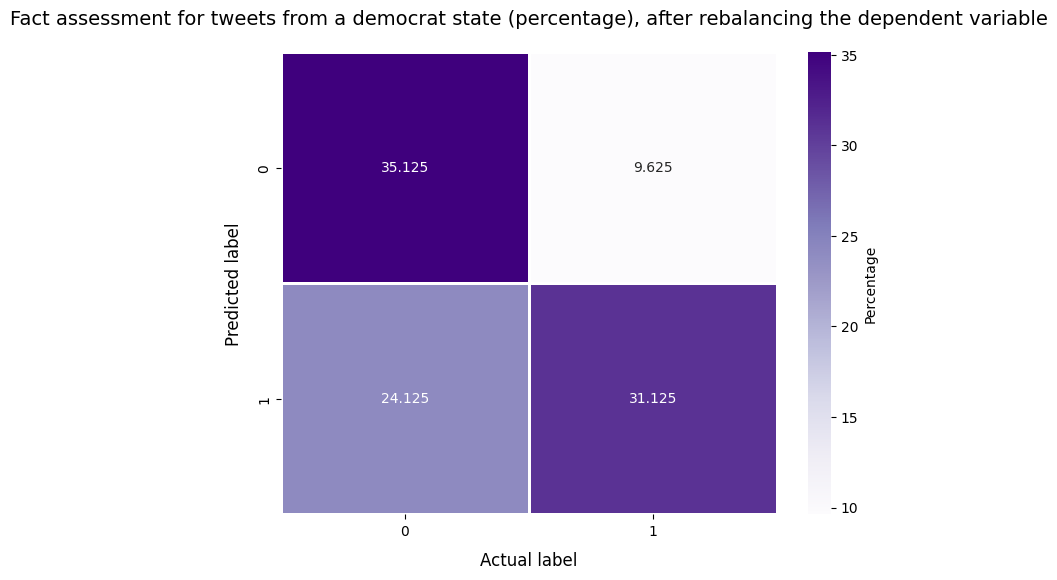

In [124]:
# Creating a crosstab
table4 = pd.crosstab(democrat_predictions_binary_fake, democrat_true_labels_fake)

# Calculate total count of all cells
total_count = table4.values.sum()

# Normalizing the table by total count
table_normalized = table4 / total_count * 100

# Rounding for easier interpretation
table_normalized = table_normalized.round(3)

plt.figure(figsize=(8, 6))

# plotting the heatmap 
ax = sns.heatmap(table_normalized, annot=True, cmap="Purples", fmt=".3f", cbar_kws={'label': 'Percentage'},linewidths=1, linecolor="white")

#title 
plt.title("Fact assessment for tweets from a democrat state (percentage), after rebalancing the dependent variable", fontsize=14, pad=20)

# the position of the labels and ticks
plt.xlabel('Actual label', fontsize=12, labelpad=10)
plt.ylabel('Predicted label', fontsize=12, labelpad=10)

# displaying the plot
plt.show()


In [125]:
prop_stat(table3, table4)

Z-statistic false negatives: -1.3314312384601033
P-value false negatives: 0.18304715636538682
There is no statistically significant difference between the two false negative proportions.
Z-statistic false positives: 1.318166567850057
P-value false positives: 0.18744789444382903
There is no statistically significant difference between the two false positive proportions.


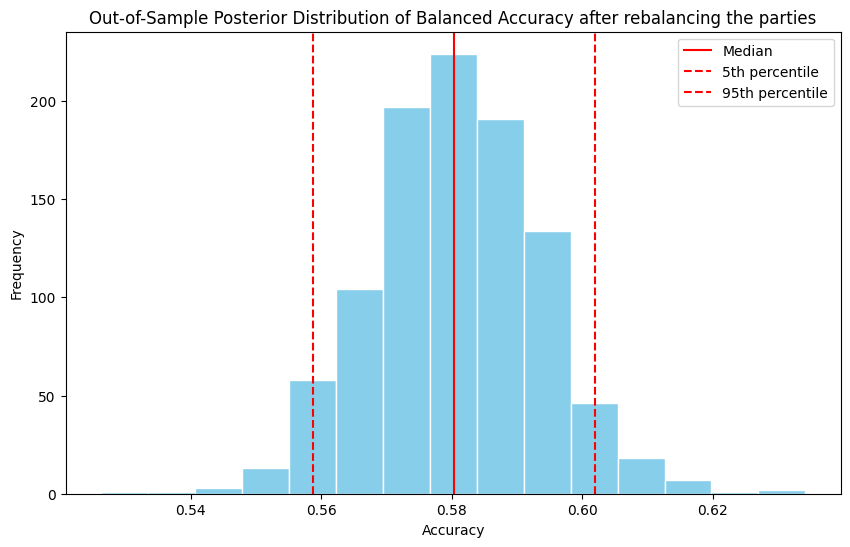

In [126]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes_party = np.random.binomial(1, predictions_party)

# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(balanced_accuracy_score(df_resampled_party['fake_binary'], simulated_outcomes_party[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Balanced Accuracy after rebalancing the parties')
plt.legend()
plt.show()

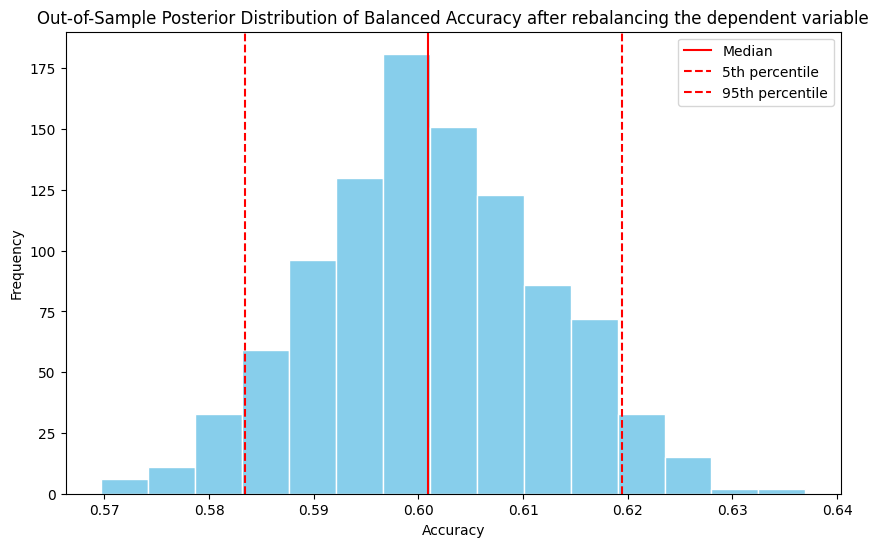

In [127]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes_fake = np.random.binomial(1, predictions_fake)

# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(balanced_accuracy_score(Xy_resampled_fake['fake_binary'], simulated_outcomes_fake[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Balanced Accuracy after rebalancing the dependent variable')
plt.legend()
plt.show()